In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os

In [2]:
# to modify based on the data directory
root_directory = os.getcwd().removesuffix('notebooks')
data_path = r'D:/Data/d18o_so/'
fig_path = root_directory + '/figures/optimization/'

In [3]:
import sys
sys.path.append(root_directory + 'scripts/') # go to parent dir

import usefull_functions as uf

%load_ext autoreload
%autoreload 2

In [4]:
if not os.path.exists(fig_path): os.mkdir(fig_path)

# Open the different files that we need

In [5]:
giss = pd.read_table(data_path + 'giss_d18o.txt')
giss_cas = pd.read_table(data_path + 'casimir_neutral_density.txt', header=None, names=['X','Y','Z','d18O','CT','SA','G','SP','TI','P'], index_col=False)
if 'gamma_n' not in giss.index:
    giss['gamma_n'] = giss_cas['G'].astype(float)
    giss['absolute_salinity'] = giss_cas['SA'].astype(float)
giss_SO = giss[giss['Latitude'] <= -40.0]

In [ ]:
# Save the modified giss dataframe to preserve data types and avoid format issues
giss.to_hdf(data_path + 'giss_d18o_modified.h5', key='data', mode='w')

File saved successfully to: D:/Data/d18o_so/giss_d18o_modified.h5


In [22]:
giss_SO['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in giss_SO['Longitude']]
giss_SO.where((giss_SO['Depth'] != -999.0) & (giss_SO['d18O'] != '**') & (giss_SO['Salinity'] != '**'), np.nan, inplace = True)
giss_SO['d18O'] = giss_SO['d18O'].astype(float)
giss_SO['Salinity'] = giss_SO['Salinity'].astype(float)

C:\Users\bm25v947\AppData\Local\Temp\ipykernel_28136\4069371636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giss_SO['Longitude'] = [lon if lon >= 0 else 360 + lon for lon in giss_SO['Longitude']]
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_28136\4069371636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giss_SO.where((giss_SO['Depth'] != -999.0) & (giss_SO['d18O'] != '**') & (giss_SO['Salinity'] != '**'), np.nan, inplace = True)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_28136\4069371636.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [24]:
giss_SO.dropna(how='all').to_csv(data_path + 'giss_d18o_SO_processed.csv', index = False)

In [25]:
aux = giss_SO.where((giss_SO['gamma_n'] <= 28.6) & (giss_SO['gamma_n'] >= 27)).dropna()
dfs = uf.create_dfs(aux)

# SO GISS compilation

## Plot the compilation

In [28]:
import custom_density_scale

<>:18: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:24: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:25: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:18: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:24: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:25: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_28136\828562499.py:18: Syntax

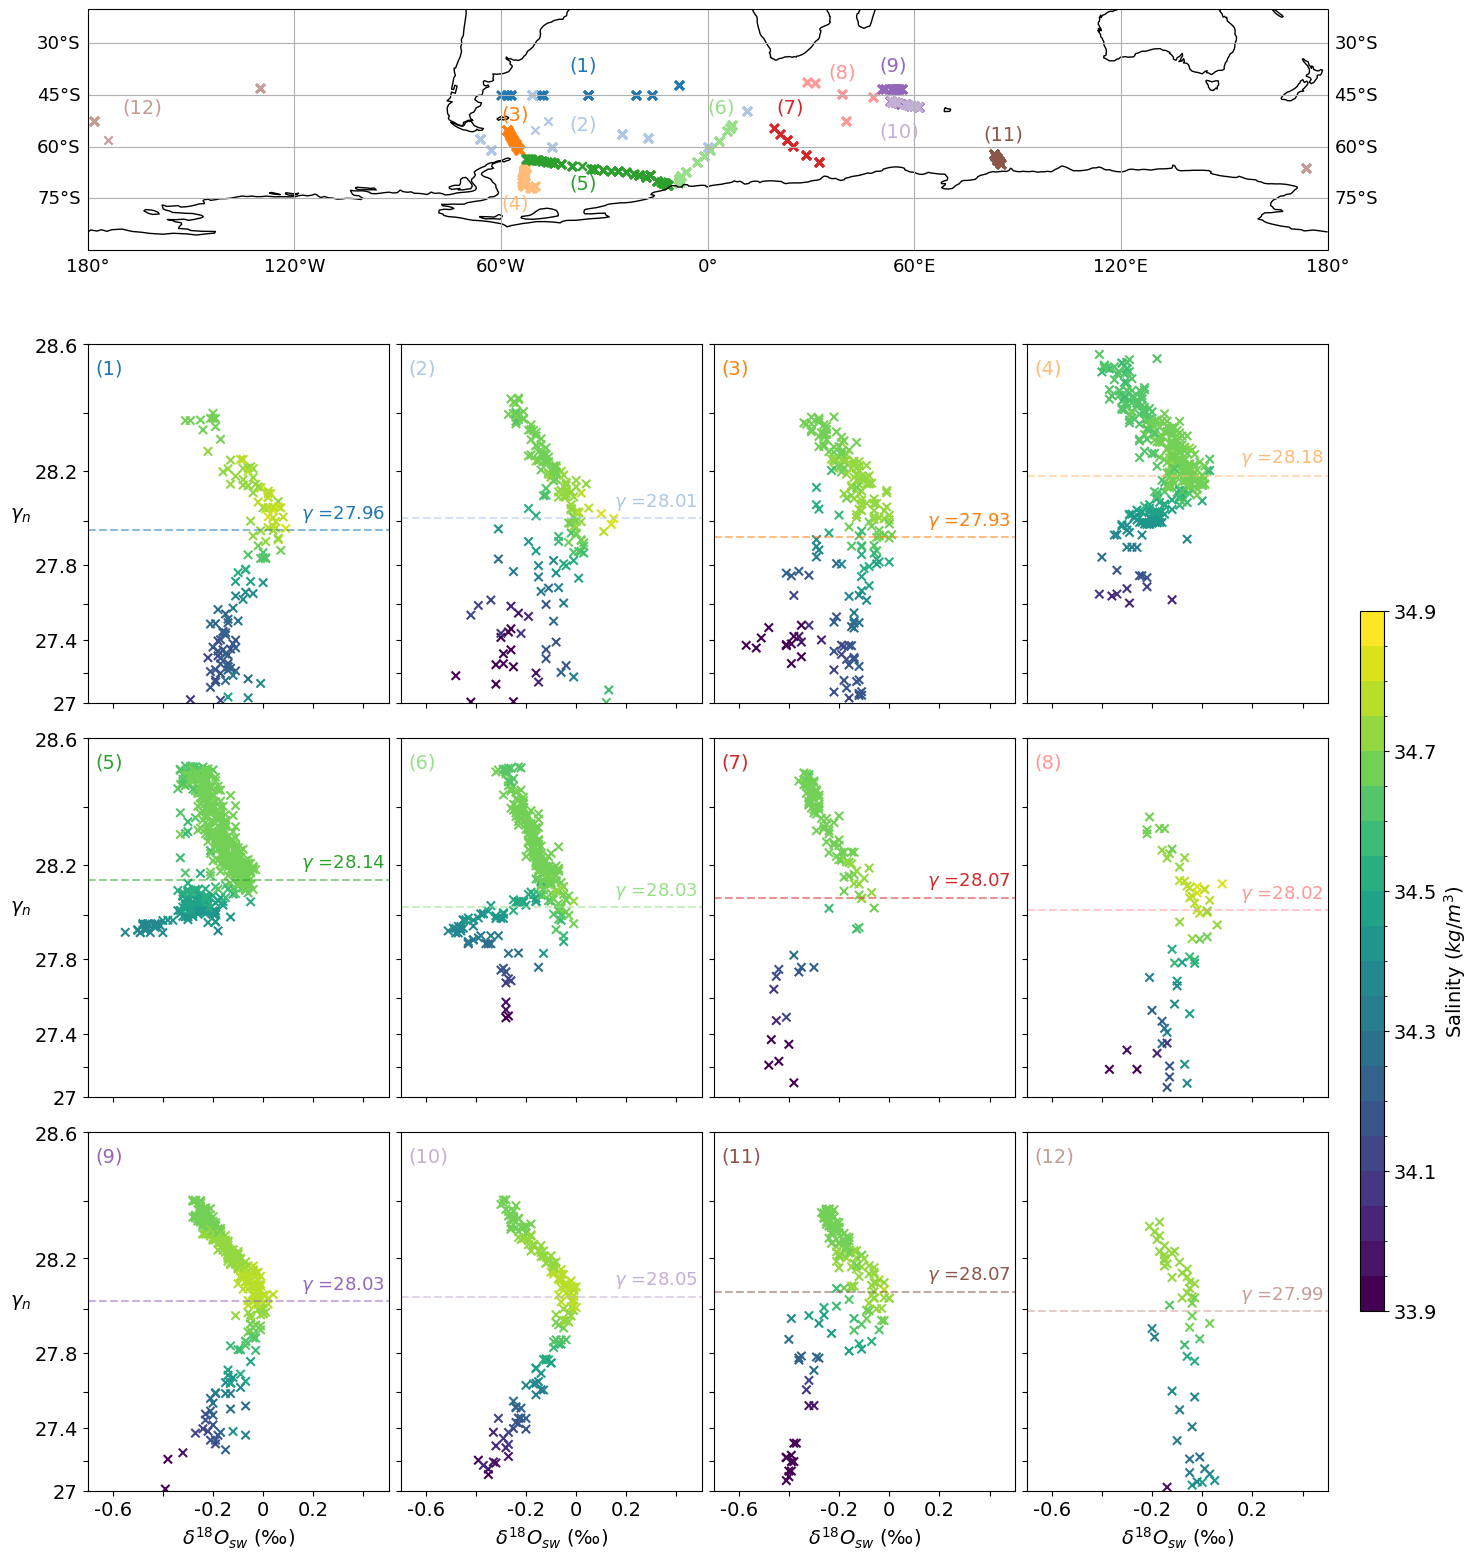

In [29]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m'); gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}; ax.set_ylim(-90, -20); ax.set_xlim(-180, 180); couleurs = plt.cm.tab20(range(12))
for i in range(12):
    ax.scatter(dfs[i]['Longitude'], dfs[i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])


norm_S = uf.get_BoundNorm(33.9, 34.9, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)

    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(dfs[i]['d18O'], dfs[i]['gamma_n'], marker = 'x', c = dfs[i]['Salinity'], norm = norm_S)
    
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.05, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    ax.text(-0.67, 28.52, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    
    ax.set_yscale('custom_scale'); ax.invert_yaxis()
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10); ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font); ax.set_xticklabels([-0.6, '', -0.2, 0, 0.2, ''], fontsize = font)
    
uf.add_cbar(fig, sc, y = 0.2, height = 0.35, fontsize = font, label = 'Salinity ($kg/m^3$)', ticks = [33.9 + i * 0.2 for i in range (6)])

plt.savefig(fig_path + 'd18o_profiles_SO_map.png', bbox_inches = 'tight')

## Plot the GISS d18o SO comp selected for the optimization

In [30]:
aux2 = aux.where(aux['Depth']>= 150).dropna()
dfs2 = uf.create_dfs(aux2)

<>:18: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:24: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:25: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:18: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:24: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:25: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_28136\1851958475.py:18: Synta

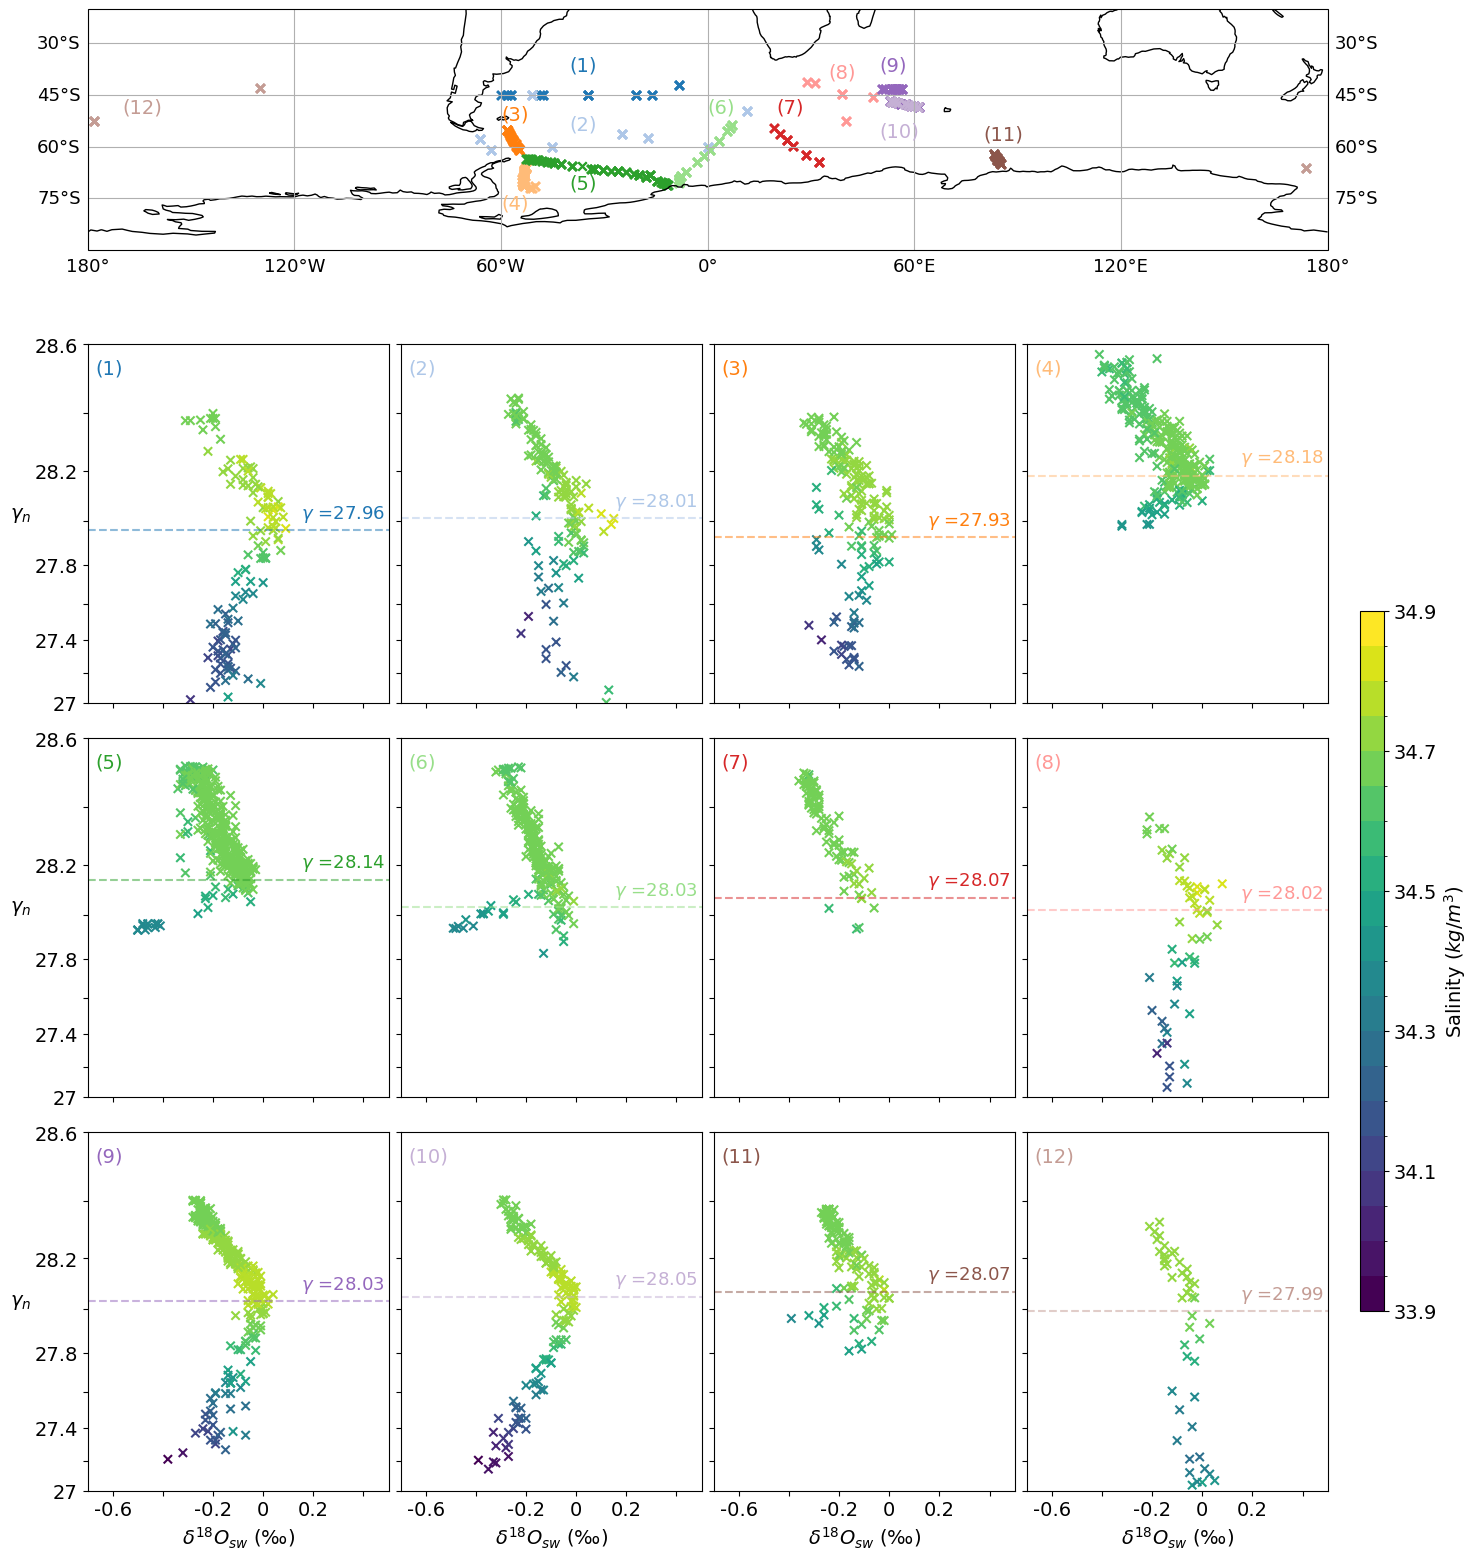

In [32]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m'); gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}; ax.set_ylim(-90, -20); ax.set_xlim(-180, 180); couleurs = plt.cm.tab20(range(12))
for i in range(12):
    ax.scatter(dfs2[i]['Longitude'], dfs2[i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])


norm_S = uf.get_BoundNorm(33.9, 34.9, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)

    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(dfs2[i]['d18O'], dfs2[i]['gamma_n'], marker = 'x', c = dfs2[i]['Salinity'], norm = norm_S)
    
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.05, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    ax.text(-0.67, 28.52, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    
    ax.set_yscale('custom_scale'); ax.invert_yaxis()
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10); ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font); ax.set_xticklabels([-0.6, '', -0.2, 0, 0.2, ''], fontsize = font)
    
uf.add_cbar(fig, sc, y = 0.2, height = 0.35, fontsize = font, label = 'Salinity ($kg/m^3$)', ticks = [33.9 + i * 0.2 for i in range (6)])

plt.savefig(fig_path + 'd18o_profiles_SO_map_optimization.png', bbox_inches = 'tight')

### Drake Passage

(-100.0, 20.0)

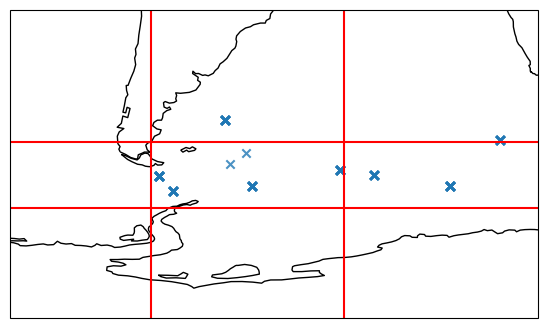

In [33]:
lon_min, lon_max = -68, -24; lat_min, lat_max = -65, -50

fig=plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0))
ax.coastlines(resolution='110m')
ax.axhline(y = lat_min, color = 'red'); ax.axhline(y = lat_max, color = 'red'); ax.axvline(x = lon_min, color ='red'); ax.axvline(x = lon_max, color ='red')
sc = ax.scatter(dfs[1]['Longitude'], dfs[1]['Latitude'], marker = 'x', alpha = 0.8)
ax.set_ylim(-90, -20); ax.set_xlim(-100, 20)

In [34]:
df_DP = dfs[1].where((dfs[1]['Longitude'] >= 360 + lon_min) & (dfs[1]['Longitude'] <= 360 + lon_max) & (dfs[1]['Latitude'] >= lat_min) & (dfs[1]['Latitude'] <= lat_max)).dropna(how = 'all')
df_Atl = dfs[1].where((dfs[1]['Longitude'] < 360 + lon_min) | (dfs[1]['Longitude'] > 360 + lon_max) | (dfs[1]['Latitude'] < lat_min) | (dfs[1]['Latitude'] > lat_max)).dropna(how = 'all')

<>:7: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:7: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:8: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:18: SyntaxWarning: "\g" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\g"? A raw string is also an option.
<>:20: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:22: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:22: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will n

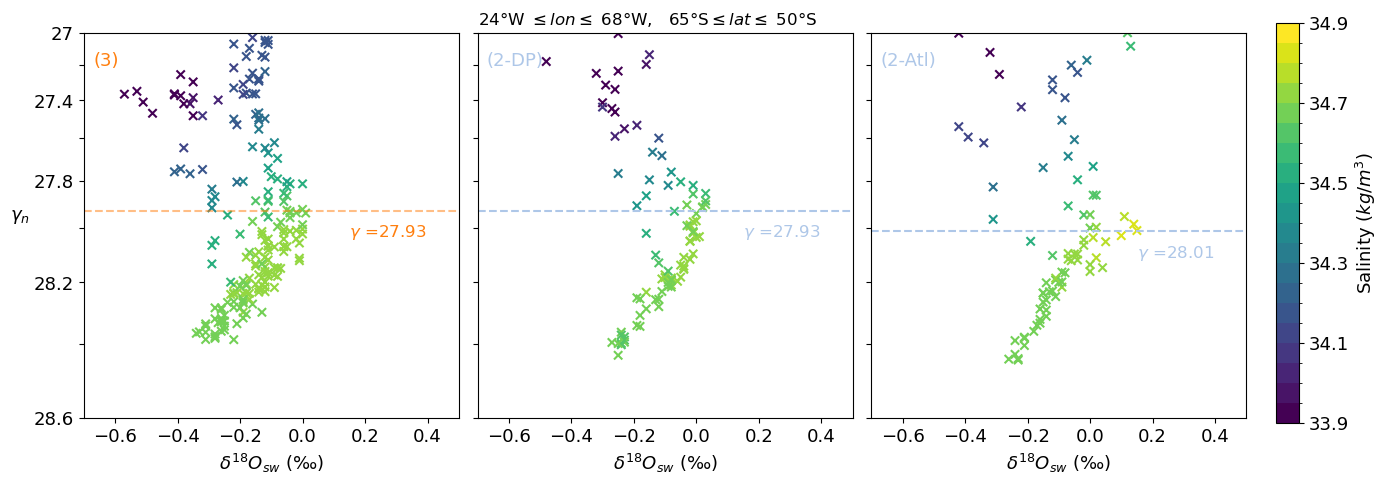

In [35]:
fig = plt.figure(figsize = (15, 5)); gs = fig.add_gridspec(1, 3, wspace = 0.05)
font = 13

ax = fig.add_subplot(gs[0, 0])
gamma = 27.93
sc = ax.scatter(dfs[2]['d18O'], dfs[2]['gamma_n'], marker = 'x', c = dfs[2]['Salinity'], norm = norm_S)
ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font); ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)
ax.axhline(y = gamma, ls = '--', color = couleurs[2], alpha = 0.5); ax.text(0.15,gamma + 0.1, '$\gamma$ =' + str(gamma), fontsize = font - 1, color = couleurs[2])
ax.text(-0.67, 27.2, '(3)', fontsize = font, color = couleurs[2])
uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font)
ax.set_yscale('custom_scale')
ax.invert_yaxis()
ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
    
ax = fig.add_subplot(gs[0, 1])
gamma = 27.93
sc = ax.scatter(df_DP['d18O'], df_DP['gamma_n'], marker = 'x', c = df_DP['Salinity'], norm = norm_S)
ax.axhline(y = gamma, ls = '--', color = couleurs[1]); ax.text(0.15,gamma + 0.1, '$\gamma$ =' + str(gamma), fontsize = font - 1, color = couleurs[1])
ax.text(-0.67, 27.2, '(2-DP)', fontsize = font, color = couleurs[1])
ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, ylabels = False)
ax.set_title('24°W $\leq lon \leq$ 68°W,   ' + '65°S$\leq lat \leq$ 50°S', fontsize = font - 1, loc = 'left')
ax.set_yscale('custom_scale')
ax.invert_yaxis()
ax.set_yticklabels([])
    
ax = fig.add_subplot(gs[0, 2])
gamma = 28.01
sc = ax.scatter(df_Atl['d18O'], df_Atl['gamma_n'], marker = 'x', c = df_Atl['Salinity'], norm = norm_S)
ax.axhline(y = gamma, ls = '--', color = couleurs[1]); ax.text(0.15,gamma + 0.1, '$\gamma$ =' + str(gamma), fontsize = font - 1, color = couleurs[1])
ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
ax.text(-0.67, 27.2, '(2-Atl)', fontsize = font, color = couleurs[1])
uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, ylabels = False)
ax.set_yscale('custom_scale')
ax.invert_yaxis()
ax.set_yticklabels([])
    
uf.add_cbar(fig, sc, fontsize = font, label = 'Salinity ($kg/m^3$)', ticks = [33.9 + i * 0.2 for i in range (6)])


plt.savefig(fig_path + 'd18o_profiles_DP_map.png', bbox_inches = 'tight')

# Optimization

In [10]:
from tracer_optimization import TracerOptimizer

## Optimizing d18o

In [11]:
optimizer = TracerOptimizer(data_path)

In [12]:
# Replicate the d18O optimization using the module
d18o_initial_values = np.array([0.45, -0.3, -0.35, -0.2, 0.3, -0.4])

# Set up the same bounds as used above
lower_bounds = np.full(6, -1.0); upper_bounds = np.full(6, 1.0)
lower_bounds[0] = 0.4499; upper_bounds[0] = 0.4501  # dyeLL fixed
lower_bounds[2] = -0.3501; upper_bounds[2] = -0.3499  # dyeNP fixed
d18o_bounds = (lower_bounds, upper_bounds)

# Run the complete optimization workflow
d18o_results_module = optimizer.run_complete_optimization(
    tracer_file='giss_d18o_modified.h5',
    tracer_column='d18O',
    initial_values=d18o_initial_values,
    bounds=d18o_bounds,
    min_depth=150.0,
    gamma_range=(27.0, 28.6),
    latitude_threshold=-40.0
)

Loading model data...
Setting up interpolators...
Running complete optimization workflow for d18O...
Preparing tracer data from giss_d18o_modified.h5...
Tracer data prepared. Final dataset contains 2955 observations.
Starting optimization for d18O...
  Dataset 1, Model TMI: 89 valid data points
  Dataset 1, Model OCIM: 89 valid data points
  Dataset 1, Model NEMO: 89 valid data points
  Dataset 2, Model TMI: 91 valid data points
  Dataset 2, Model OCIM: 91 valid data points
  Dataset 2, Model NEMO: 91 valid data points
  Dataset 3, Model TMI: 77 valid data points
  Dataset 3, Model OCIM: 77 valid data points
  Dataset 3, Model NEMO: 77 valid data points
  Dataset 4, Model TMI: 65 valid data points
  Dataset 4, Model OCIM: 65 valid data points
  Dataset 4, Model NEMO: 65 valid data points
  Dataset 5, Model TMI: 219 valid data points
  Dataset 5, Model OCIM: 219 valid data points
  Dataset 5, Model NEMO: 219 valid data points
  Dataset 6, Model TMI: 108 valid data points
  Dataset 6, Mo

In [13]:
d18o_EM_values = d18o_results_module['optimization_results']
d18o_EM_values_TMI = np.array([result.x[:6] if result is not None else np.full(6, np.nan) for result in d18o_EM_values['TMI']]).T
d18o_EM_values_ocim = np.array([result.x[:6] if result is not None else np.full(6, np.nan) for result in d18o_EM_values['OCIM']]).T  
d18o_EM_values_nemo = np.array([result.x[:6] if result is not None else np.full(6, np.nan) for result in d18o_EM_values['NEMO']]).T

<>:12: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
<>:12: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_32616\2262998926.py:12: SyntaxWarning: "\d" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\d"? A raw string is also an option.
  if j == 0: ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_32616\2262998926.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


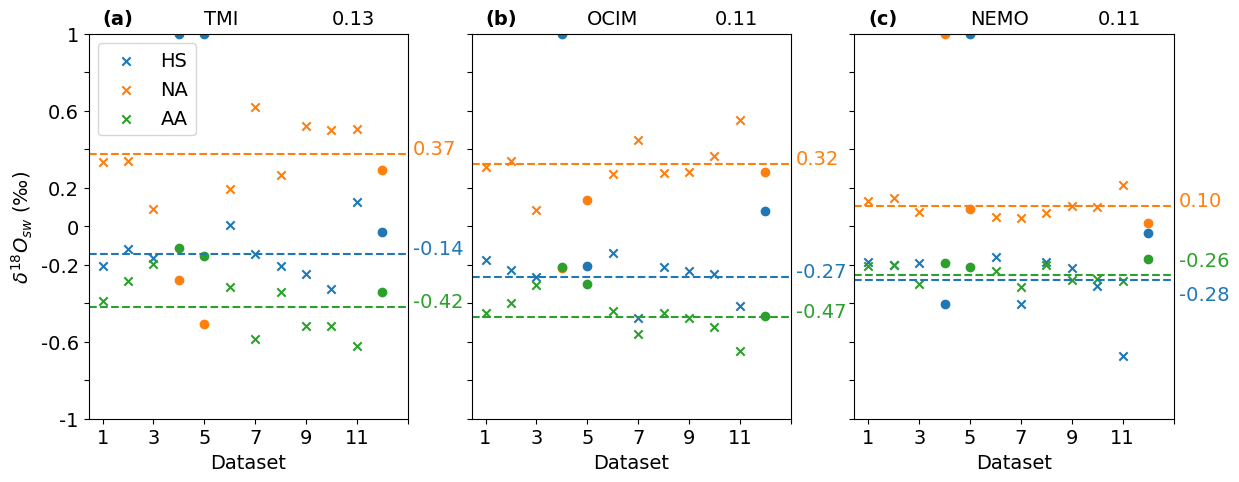

In [14]:
# Create the detailed end-member plot with exclusions and statistics (TracerOptimizer version)
fig = plt.figure(figsize = (14, 5)); gs = fig.add_gridspec(1, 3, hspace = 0.12); font = 14
module_EM_values = [d18o_EM_values_TMI, d18o_EM_values_ocim, d18o_EM_values_nemo]
models = uf.models; suffixes = ['_TMI', '_ocim', '_nemo']; dyes_TMI = uf.dyes_TMI
prop_cycle = plt.rcParams['axes.prop_cycle']; colors = prop_cycle.by_key()['color']

# Get the full tracer dataset (not just the optimization datasets)
full_tracer_data = d18o_results_module.get('tracer_data')

for j in range(3):
    ax = fig.add_subplot(gs[0, j]); ax.text(0, 1.05, uf.panels_letter_parenthesis[j], fontsize = font, fontweight = 'bold')
    if j == 0: ax.set_ylabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
    idx_to_exclude = optimizer.exclusion_indices[models[j]]['dyeHS']; idx = [k for k in range(12)]
    
    rmse_value = uf.rmse_model_recons(full_tracer_data, 'd18O', models[j], optimizer.mean_end_members)
    
    for i in [3, 4, 5]:
        ax.scatter(np.delete(idx, idx_to_exclude, 0), np.delete(module_EM_values[j][i, :], idx_to_exclude, 0), label = uf.dyes[i].replace('Dye', ''), marker = 'x', c = colors[i - 3])
        ax.scatter(idx_to_exclude, module_EM_values[j][i, idx_to_exclude], marker = 'o', c = colors[i - 3])
        
        ax.axhline(y = np.nanmean(np.delete(module_EM_values[j][i, :], idx_to_exclude, 0)), c = colors[i - 3], ls = '--')
        em_d18o_value = optimizer.mean_end_members['d18O'][models[j]][dyes_TMI[i]]
        if (j == 2) & (i == 5): ax.text(12.2, em_d18o_value + 0.05, format(em_d18o_value, '.2f'), c = colors[i - 3], fontsize = font)
        elif (j == 2) & (i == 3): ax.text(12.2, em_d18o_value - 0.1, format(em_d18o_value, '.2f'), c = colors[i - 3], fontsize = font)
        else: ax.text(12.2, em_d18o_value, format(em_d18o_value, '.2f'), c = colors[i - 3], fontsize = font)
        
    ax.set_ylim(-1, 1); ax.text(4, 1.05, models[j], fontsize = font); ax.set_xticks([k*2 for k in range(7)]); ax.set_xticklabels([str(k*2 + 1) for k in range(6)] + [''], fontsize = font); ax.set_xlabel('Dataset', fontsize = font)
    ax.set_yticks([-1 + 0.2 * k for k in range(11)]); ax.set_yticklabels([])
    if j ==0: ax.set_yticklabels([-1, '', -0.6, '', -0.2, 0, 0.2, '', 0.6, '', 1], fontsize = font); ax.legend(fontsize = font)
        
    # rmse_value = np.sqrt(np.mean((np.array(all_obs) - np.array(all_recon))**2))
    ax.text(9, 1.05, format(rmse_value, '.2f'), fontsize = font)

plt.tight_layout()
# plt.savefig(fig_path + 'd18o_values_EM_12_datasets_3models.png', bbox_inches = 'tight')

## Optimizing Salinity

In [15]:
salinity_optimizer = TracerOptimizer(data_path)

# Define proper bounds for salinity optimization (PSU values typically 33.5-36.0)
salinity_lower_bounds = np.array([35.4999, 33.5, 33.4999, 33.5, 33.5, 33.5])
salinity_upper_bounds = np.array([35.5001, 35.5, 33.5001, 35.5, 35.5, 35.5])
salinity_bounds = (salinity_lower_bounds, salinity_upper_bounds)

tracer = 'absolute_salinity'

salinity_results = salinity_optimizer.run_complete_optimization(
    tracer_file='giss_d18o_SO_processed.csv',
    tracer_column=tracer,
    initial_values=np.array([35.5, 34.6, 33.5, 34.8, 34.7, 34.4]),  # Initial PSU values
    bounds=salinity_bounds,  # Add proper bounds
    min_depth=150.0,
    gamma_range=(27.0, 28.6),
    latitude_threshold=-40.0
)

salinity_EM_values = salinity_results['optimization_results']
salinity_EM_values_TMI = np.array([result.x[:6] if result is not None else np.full(6, np.nan) for result in salinity_EM_values['TMI']]).T
salinity_EM_values_ocim = np.array([result.x[:6] if result is not None else np.full(6, np.nan) for result in salinity_EM_values['OCIM']]).T  
salinity_EM_values_nemo = np.array([result.x[:6] if result is not None else np.full(6, np.nan) for result in salinity_EM_values['NEMO']]).T

Loading model data...
Setting up interpolators...
Running complete optimization workflow for absolute_salinity...
Preparing tracer data from giss_d18o_SO_processed.csv...
Tracer data prepared. Final dataset contains 2955 observations.
Starting optimization for absolute_salinity...
  Dataset 1, Model TMI: 89 valid data points
  Dataset 1, Model OCIM: 89 valid data points
  Dataset 1, Model NEMO: 89 valid data points
  Dataset 2, Model TMI: 91 valid data points
  Dataset 2, Model OCIM: 91 valid data points
  Dataset 2, Model NEMO: 91 valid data points
  Dataset 3, Model TMI: 77 valid data points
  Dataset 3, Model OCIM: 77 valid data points
  Dataset 3, Model NEMO: 77 valid data points
  Dataset 4, Model TMI: 65 valid data points
  Dataset 4, Model OCIM: 65 valid data points
  Dataset 4, Model NEMO: 65 valid data points
  Dataset 5, Model TMI: 219 valid data points
  Dataset 5, Model OCIM: 219 valid data points
  Dataset 5, Model NEMO: 219 valid data points
  Dataset 6, Model TMI: 108 va

In [16]:
# Extract the calculated statistics
salinity_mean_EM = np.empty((3, 6)); salinity_std_EM = np.empty((3, 6))
models = uf.models; dyes_TMI = uf.dyes_TMI

for i, model in enumerate(models):
    salinity_mean_EM[i] = list(salinity_optimizer.mean_end_members[tracer][model].values())
    salinity_std_EM[i] = list(salinity_optimizer.std_end_members[tracer][model].values())

salinity_EM_plot_values = [salinity_EM_values_TMI, salinity_EM_values_ocim, salinity_EM_values_nemo]

C:\Users\bm25v947\AppData\Local\Temp\ipykernel_32616\3343451307.py:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


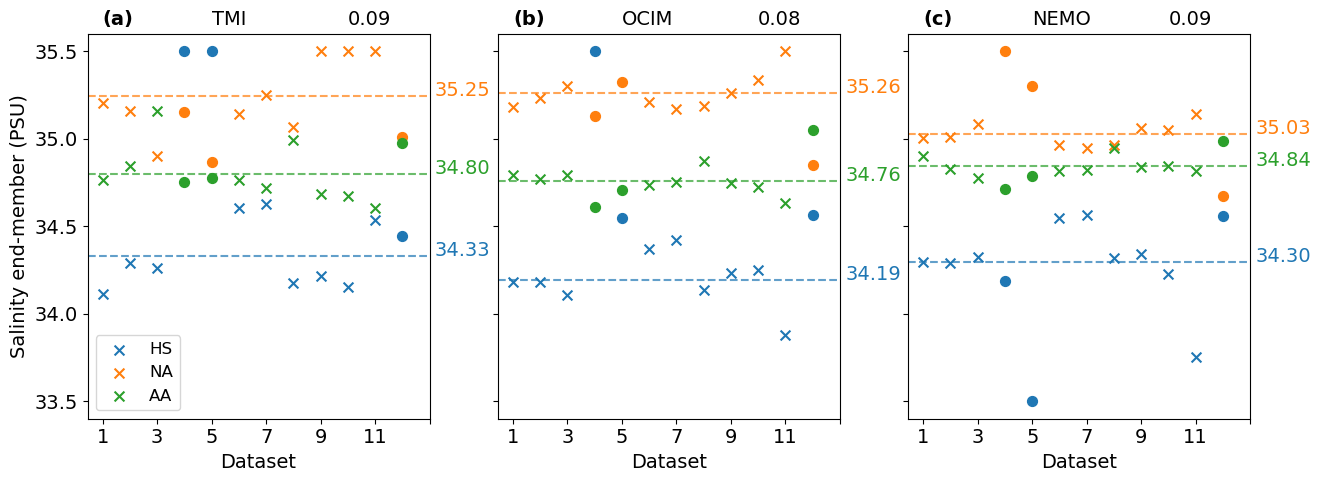

In [17]:
fig = plt.figure(figsize=(15, 5)); gs = fig.add_gridspec(1, 3, hspace=0.12)
models = ['TMI', 'OCIM', 'NEMO']; suffixes = ['_TMI', '_ocim', '_nemo']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']; font = 14

full_tracer_data = salinity_results.get('tracer_data')

for j in range(3):
    ax = fig.add_subplot(gs[0, j]); ax.text(0, 35.65, uf.panels_letter_parenthesis[j], fontsize = font, fontweight = 'bold')
    ax.text(4, 35.65, models[j], fontsize=font)
    
    idx_to_exclude = salinity_optimizer.exclusion_indices[models[j]]['dyeHS']; idx = [k for k in range(12)]
    rmse_value = uf.rmse_model_recons(full_tracer_data, tracer, models[j], salinity_optimizer.mean_end_members)
    ax.text(9, 35.65, format(rmse_value, '.2f'), fontsize=font)
    
    for i in [3, 4, 5]:
        ax.scatter(np.delete(idx, idx_to_exclude, 0), np.delete(salinity_EM_plot_values[j][i, :], idx_to_exclude, 0), label=uf.dyes[i].replace('Dye', ''), marker='x', c=colors[i-3], s=50)
        ax.scatter(idx_to_exclude, salinity_EM_plot_values[j][i, idx_to_exclude], marker='o', c=colors[i-3], s=50)
        
        mean_val = np.nanmean(np.delete(salinity_EM_plot_values[j][i, :], idx_to_exclude, 0))
        ax.axhline(y=mean_val, c=colors[i-3], ls='--', alpha=0.7)

        em_S_value = salinity_optimizer.mean_end_members[tracer][models[j]][dyes_TMI[i]]
        ax.text(12.2, em_S_value, format(em_S_value, '.2f'), c = colors[i - 3], fontsize = font)

    ax.set_ylim(33.4, 35.6); ax.set_yticks([33.5, 34.0, 34.5, 35.0, 35.5])
    ax.set_xticks([i*2 for i in range(7)]); ax.set_xticklabels([str(i*2 + 1) for i in range(6)] + [''], fontsize=font); ax.set_xlabel('Dataset', fontsize=font)
    
    if j == 0:
        ax.set_ylabel('Salinity end-member (PSU)', fontsize=font)
        ax.set_yticklabels([33.5, 34.0, 34.5, 35.0, 35.5], fontsize=font)
        ax.legend(fontsize=font-2)
    else:
        ax.set_yticklabels([])

plt.tight_layout()
# plt.savefig(fig_path + 'absolute_salinity_values_EM_12_datasets_3models.png', bbox_inches='tight')

## End-member d18o-S diagram

In [18]:
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

In [20]:
dsClim = xr.open_dataset(data_path + 'climatology_Brunov2.nc')

mask_md, mask_d = (dsClim['basin_masks'] == 14) & (dsClim['depth'] >= 2000) & (dsClim['depth'] <= 3000), (dsClim['basin_masks'] == 14) & (dsClim['depth'] >= 3000) 
salinity_md, d18o_md = np.nanmean(dsClim['absolute_salinity'].where(mask_md)), np.nanmean(dsClim['seawater_d18O'].where(mask_md))
salinity_d, d18o_d = np.nanmean(dsClim['absolute_salinity'].where(mask_d)), np.nanmean(dsClim['seawater_d18O'].where(mask_d))

In [21]:
salinity_md, d18o_md

(np.float64(34.64133623834117), np.float64(-0.0303163757450739))

In [23]:
salinity_optimizer.mean_end_members

{'absolute_salinity': {'TMI': {'dyeLL': np.float64(35.50003333179288),
   'dyeMS': np.float64(34.901117113196605),
   'dyeNP': np.float64(33.50000000087038),
   'dyeHS': np.float64(34.330574273459575),
   'dyeNA': np.float64(35.24693425266685),
   'dyeAA': np.float64(34.79988480429672)},
  'OCIM': {'dyeLL': np.float64(35.50005002319501),
   'dyeMS': np.float64(35.02178597587062),
   'dyeNP': np.float64(33.500049999981805),
   'dyeHS': np.float64(34.19477050652885),
   'dyeNA': np.float64(35.26356461124309),
   'dyeAA': np.float64(34.757952403014805)},
  'NEMO': {'dyeLL': np.float64(35.500033333328226),
   'dyeMS': np.float64(34.95632802060138),
   'dyeNP': np.float64(33.50004999999289),
   'dyeHS': np.float64(34.2955174773568),
   'dyeNA': np.float64(35.02514793740191),
   'dyeAA': np.float64(34.84309542371696)}}}

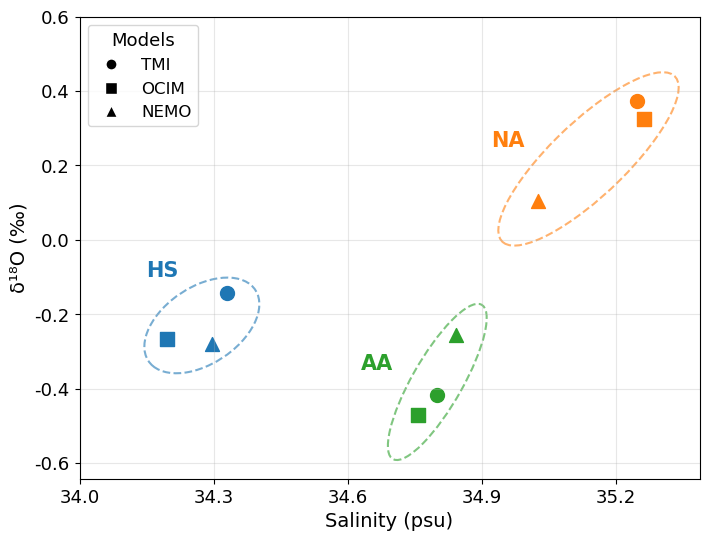

In [ ]:
fig = plt.figure(figsize=(8, 6)); font = 14; ax = plt.gca()
markers = ['o', 's', '^']
angles_ellipses = [-45, -40, -25]; ratio_width = [2/3, 1/3, 2/3]
offset_center = [(0, 0), (0.04, 0.05), (0, 0)]

for imodel, model in enumerate(models):
    for i in range(3):
        ax.scatter(salinity_optimizer.mean_end_members['absolute_salinity'][model][dyes_TMI[i+3]], optimizer.mean_end_members['d18O'][model][dyes_TMI[i+3]], marker=markers[imodel], s=100, color = colors[i])
for i in [3, 4, 5]:    
    # Add ellipse around valid data points
    valid_s = [values[dyes_TMI[i]] for values in salinity_optimizer.mean_end_members['absolute_salinity'].values()]
    valid_d18o = [values[dyes_TMI[i]] for values in optimizer.mean_end_members['d18O'].values()]
    
    center_x = np.mean(valid_s); center_y = np.mean(valid_d18o)
    width = 5 * np.std(valid_s)*ratio_width[i-3]; height = 5 * np.std(valid_d18o)
    
    ellipse = Ellipse(xy=(center_x - offset_center[i-3][0], center_y - offset_center[i-3][1]), width=width, height=height, facecolor='none', edgecolor=colors[i-3], 
                    alpha=0.6, linewidth=1.5, linestyle='--', angle=angles_ellipses[i-3])

    ax.add_patch(ellipse)

# Create legend for water masses (symbols)
water_mass_legend_elements = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[0], markersize=8, label='HS'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[1], markersize=8, label='NA'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[2], markersize=8, label='AA')
]

# Create legend for models (colors)
model_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='TMI'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markersize=8, label='OCIM'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=8, label='NEMO')
]

# legend1 = ax.legend(handles=water_mass_legend_elements, loc='upper left', title='Water Masses', fontsize=font-2, title_fontsize=font-1)
legend2 = ax.legend(handles=model_legend_elements, loc='upper left', title='Models', fontsize=font-2, title_fontsize=font-1)
# ax.add_artist(legend1)

# ax.scatter(salinity_md, d18o_md, marker='x', color = 'black')
# ax.scatter(salinity_d, d18o_d, marker='o', color = 'black')

ax.text(34.15, -0.1, 'HS', fontsize=font+1, color=colors[0], fontweight='bold')
ax.text(34.92, 0.25, 'NA', fontsize=font+1, color=colors[1], fontweight='bold')
ax.text(34.63, -0.35, 'AA', fontsize=font+1, color=colors[2], fontweight='bold')

ax.set_xlabel('Salinity (psu)', fontsize=font); ax.set_ylabel('δ¹⁸O (‰)', fontsize=font)
ax.set_xticks([34 + 0.3*i for i in range(5)]); ax.set_yticks([-0.6 + 0.2*i for i in range(7)])
ax.set_xticklabels([format(34 + 0.3*i, '.1f') for i in range(5)], fontsize=font-1); ax.set_yticklabels([format(-0.6 + 0.2*i, '.1f') for i in range(7)], fontsize=font-1)
ax.grid(True, alpha=0.3)

# plt.savefig(fig_path + 'absolute_salinity_d18o_endmembers.png', bbox_inches='tight')

## Reconstruct each dataset from its d18o EM found

### Individual dataset

In [ ]:
model = 'OCIM' # 'NEMO', 'TMI' or 'OCIM'

<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:26: SyntaxWarning: invalid escape sequence '\g'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:29: SyntaxWarning: invalid escape sequence '\g'
<>:31: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_10568\2825447420.py:26: SyntaxWarning: invalid escape sequence '\g'
  ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.1, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_10568\2825447420.py:28: SyntaxWarning: invalid escape sequence '\d'
  if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_10568\2825447420.py:29: SyntaxWarning: in

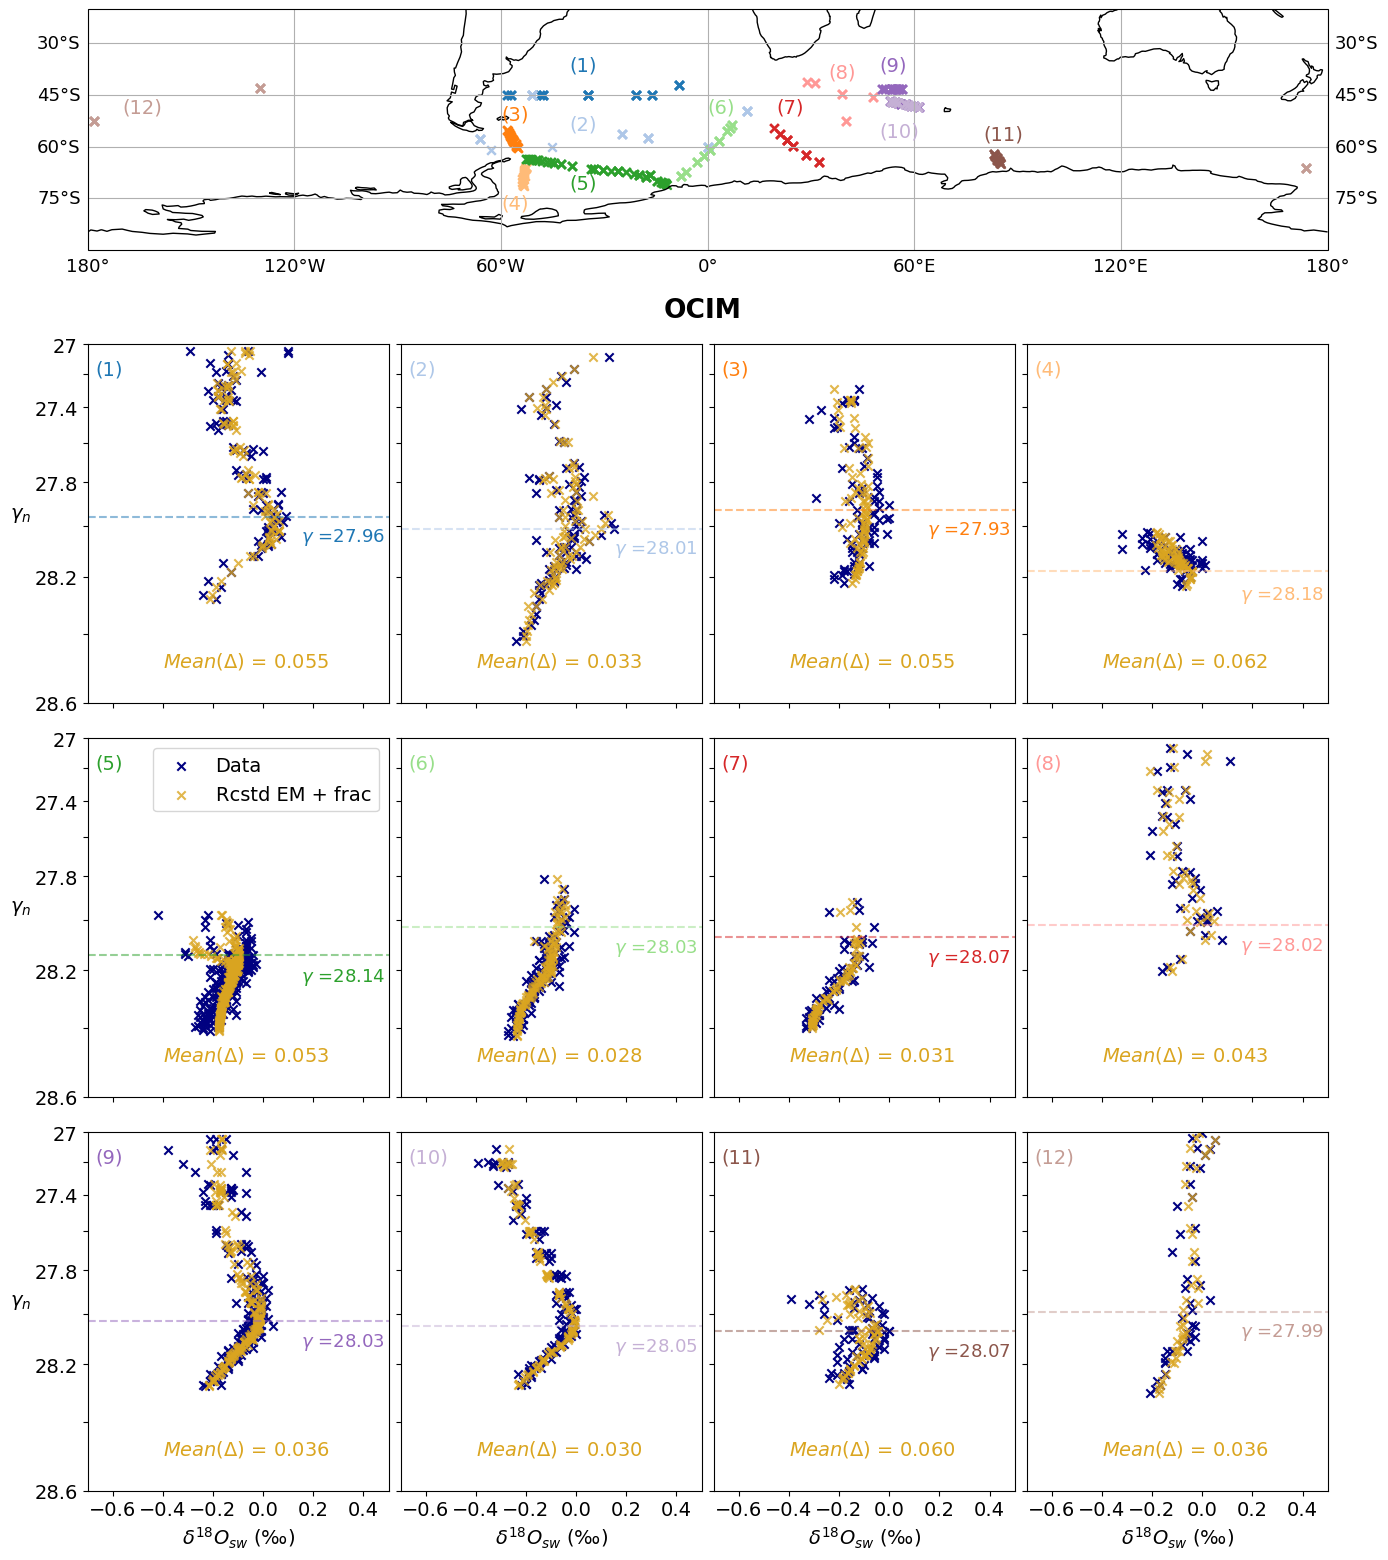

In [ ]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}
ax.set_ylim(-90, -20); ax.set_xlim(-180, 180)
couleurs = plt.cm.tab20(range(12))

for i in range(12):
    ax.scatter(d18o_results_module['datasets'][i]['Longitude'], d18o_results_module['datasets'][i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])

norm_S = uf.get_BoundNorm(34, 35, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)
    
    if (i_row == 1) & (i_col==2): ax.text(0.35, 26.8, model, fontsize = font + 5, fontweight = 'bold')
        
    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(d18o_results_module['datasets'][i]['d18O'], d18o_results_module['datasets'][i]['Gamma'], marker = 'x', c = 'navy', alpha = 1, label = 'Data') #, norm = norm_S)
    ax.scatter(d18o_results_module['datasets'][i]['d18O_rcst_' + model], d18o_results_module['datasets'][i]['Gamma'], marker = 'x', c = 'goldenrod', alpha = .8, label = 'Rcstd EM + frac')
# ax.scatter(dfs[i]['d18O_ocim_rcstd'], dfs[i]['Gamma'], marker = 'x', c = 'navy', alpha = 0.5)

    if i ==4: ax.legend(fontsize = font)
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.1, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)

    ax.text(-0.4, 28.5, '$Mean(\Delta)$ = ' + format(np.sqrt(np.nanmean((d18o_results_module['datasets'][i]['d18O'] - d18o_results_module['datasets'][i]['d18O_rcst_' + model])**2)), '.3f'), fontsize = font, color = 'goldenrod')
    ax.text(-0.67, 27.2, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    
    ax.set_yscale('custom_scale')
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    ax.invert_yaxis()
    if ylabels: ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)

# plt.savefig(fig_path + 'd18o_profiles_SO_map_' + model + '_rcs_dataset.png', bbox_inches = 'tight')

### With mean reconstruction

<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
<>:25: SyntaxWarning: invalid escape sequence '\g'
<>:27: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\g'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:31: SyntaxWarning: invalid escape sequence '\D'
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_10568\128244964.py:25: SyntaxWarning: invalid escape sequence '\g'
  ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.1, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
C:\Users\bm25v947\AppData\Local\Temp\ipykernel_10568\128244964.py:27: SyntaxWarning: invalid escape sequence '\d'
  if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fonts

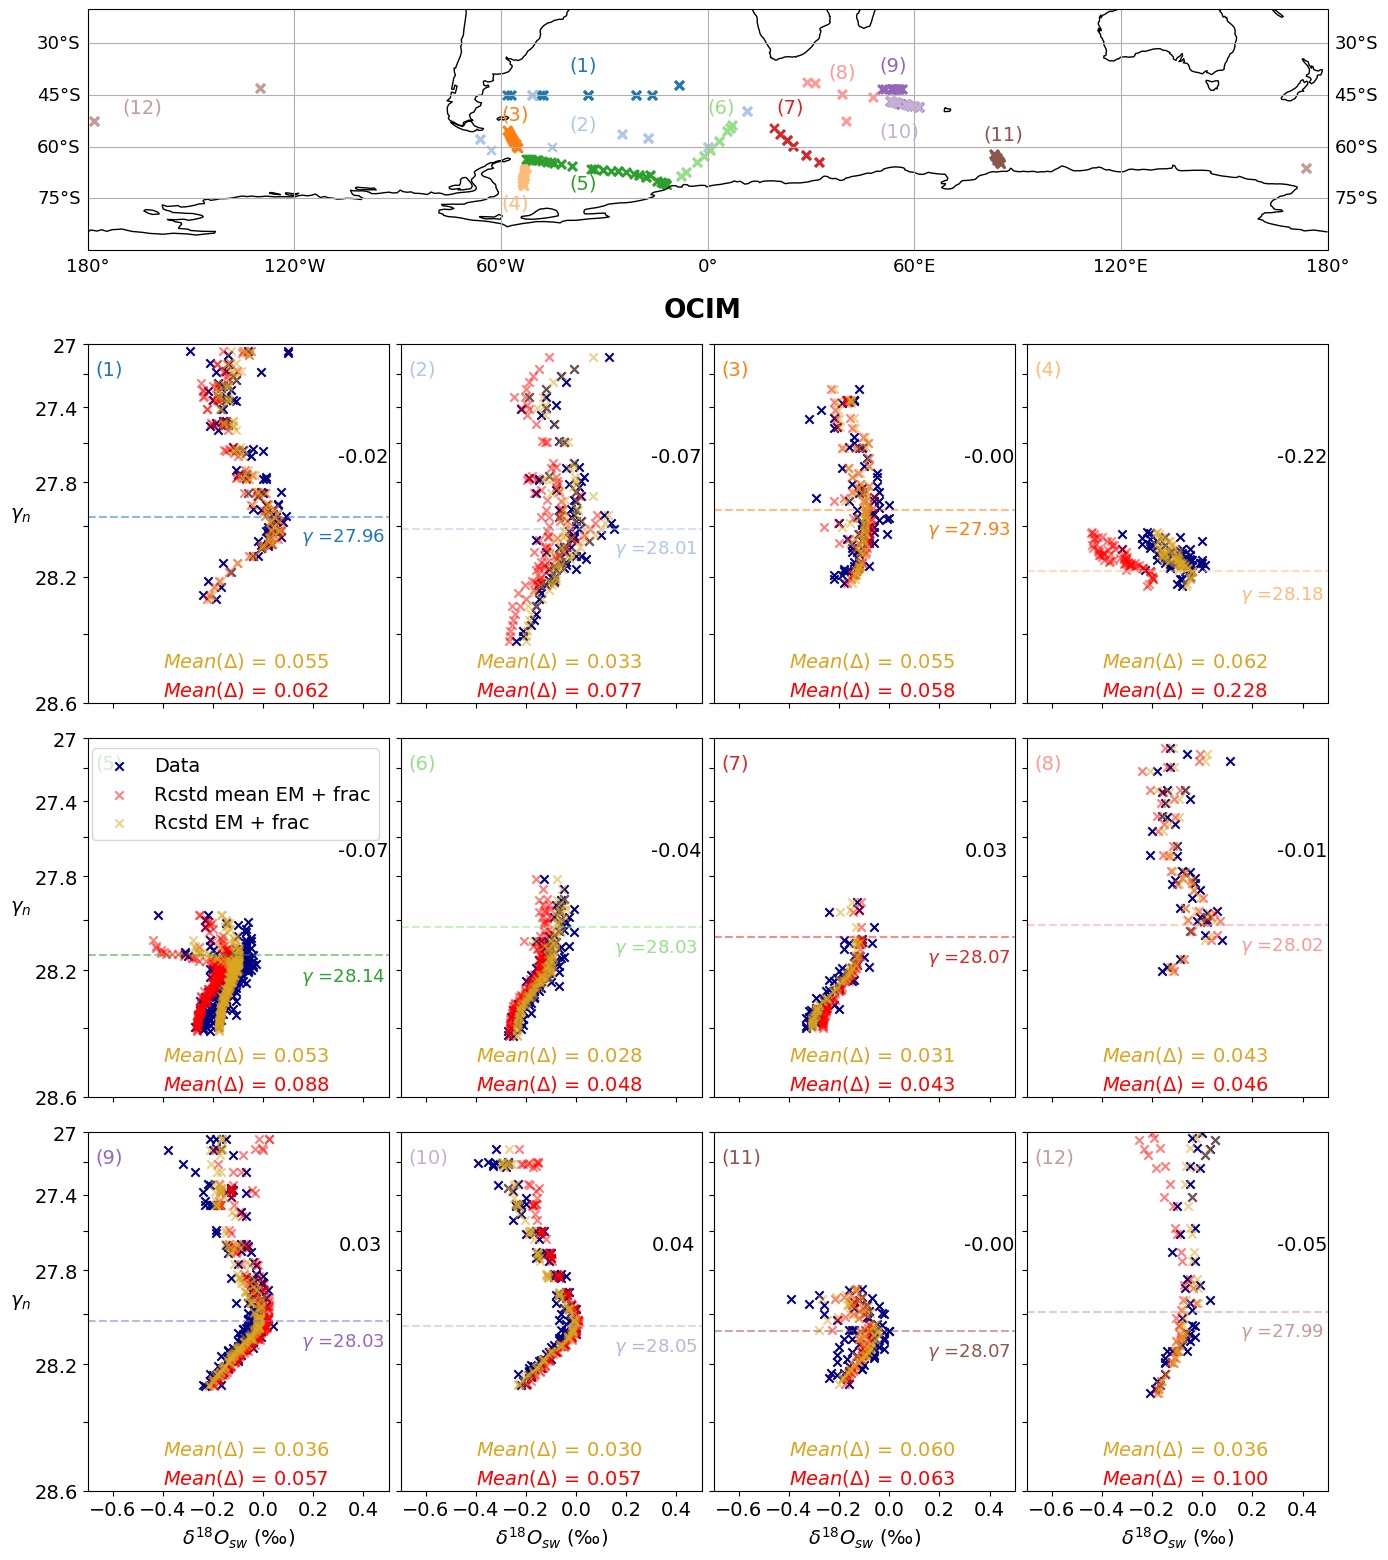

In [ ]:
fig = plt.figure(figsize = (16, 20)); gs = fig.add_gridspec(4, 4, wspace = 0.04, hspace = 0.1); font = 14

ax = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
ax.coastlines(resolution='110m')
gl = ax.gridlines(draw_labels = {'bottom': 'x', 'right': 'y', 'left': 'y'}, ylocs = [-90 + 15 * i for i in range(5)])
gl.xlabel_style = {'size': font - 1}; gl.ylabel_style = {'size': font - 1}
ax.set_ylim(-90, -20); ax.set_xlim(-180, 180)
couleurs = plt.cm.tab20(range(12))
for i in range(12):
    ax.scatter(d18o_results_module['datasets'][i]['Longitude'], d18o_results_module['datasets'][i]['Latitude'], color = couleurs[i], marker = 'x')
    ax.text(uf.coords_dataset[i][0], uf.coords_dataset[i][1], '(' + str(i+1) + ')', fontsize = font, color = couleurs[i])

norm_S = uf.get_BoundNorm(34, 35, nbins = 20)
for i in range(12):
    i_row, i_col = i//4 + 1, i%4; xlabels, ylabels = uf.get_xylabels(3, 4, i)
    
    if (i_row == 1) & (i_col==2): ax.text(0.35, 26.8, model, fontsize = font + 5, fontweight = 'bold')
        
    ax = fig.add_subplot(gs[i_row, i_col])
    sc = ax.scatter(d18o_results_module['datasets'][i]['d18O'], d18o_results_module['datasets'][i]['Gamma'], marker = 'x', c = 'navy', alpha = 1, label = 'Data') #, norm = norm_S)
    ax.scatter(d18o_results_module['datasets'][i]['d18O_rcst_mean_' + model], d18o_results_module['datasets'][i]['Gamma'], marker = 'x', c = 'red', alpha = .5, label = 'Rcstd mean EM + frac')
    ax.scatter(d18o_results_module['datasets'][i]['d18O_rcst_' + model], d18o_results_module['datasets'][i]['Gamma'], marker = 'x', c = 'goldenrod', alpha = .5, label = 'Rcstd EM + frac')

    if i ==4: ax.legend(fontsize = font)
    ax.axhline(y = uf.l_neut_dens[i], ls = '--', color = couleurs[i], alpha = 0.5); ax.text(0.15, uf.l_neut_dens[i] + 0.1, '$\gamma$ =' + str(uf.l_neut_dens[i]), fontsize = font - 1, color = couleurs[i])
    
    if xlabels: ax.set_xlabel('$\delta^{18}O_{sw}$ (‰)', fontsize = font)
    if ylabels: ax.set_ylabel('$\gamma_n$', fontsize = font, rotation = 0, labelpad = 10)

    ax.text(-0.4, 28.5, '$Mean(\Delta)$ = ' + format(np.sqrt(np.nanmean((d18o_results_module['datasets'][i]['d18O'] - d18o_results_module['datasets'][i]['d18O_rcst_' + model])**2)), '.3f'), fontsize = font, color = 'goldenrod')
    ax.text(-0.4, 28.58, '$Mean(\Delta)$ = ' + format(np.sqrt(np.nanmean((d18o_results_module['datasets'][i]['d18O'] - d18o_results_module['datasets'][i]['d18O_rcst_mean_' + model])**2)), '.3f'), fontsize = font, color = 'red')
    ax.text(-0.67, 27.2, '(' + str(i + 1) + ')', fontsize = font, color = couleurs[i])
    ax.text(0.3, 27.7, format(np.nanmean(d18o_results_module['datasets'][i]['d18O_rcst_mean_' + model] - d18o_results_module['datasets'][i]['d18O']), '.2f'), fontsize = font)
    
    ax.set_yscale('custom_scale')
    uf.plot_details_axis(ax, sc, cb = False, xlim = (-0.7, 0.5), ylim = (28.6, 27), nbins = 20, xticks = [-0.6 + 0.2*i for i in range(6)], yticks = [27 + 0.2*i for i in range(9)], font = font, xlabels = xlabels, ylabels = ylabels)
    ax.invert_yaxis()
    if ylabels: ax.set_yticklabels(['27', '', '27.4', '', '27.8', '', '28.2', '', '28.6'], fontsize = font)
# uf.add_cbar(fig, sc, y = 0.2, height = 0.35, fontsize = font, label = 'Salinity ($kg/m^3$)', ticks = [34 + i * 0.2 for i in range (6)])

plt.savefig(fig_path + 'd18o_profiles_SO_map_' + model + '_rcs_dataset_&mean.png', bbox_inches = 'tight')

## Save reconstructed products

In [ ]:
# Simple function to get mean end-member values from optimizer
def compute_EM_values(model):
    """Get mean end-member values for a specific model"""
    mean_values = []
    for dye in uf.dyes_TMI:
        mean_values.append(optimizer.mean_end_members['d18O'][model][dye])
    return mean_values

In [ ]:
nemo_dyes_regridded = xr.open_dataset(data_path + 'tm21ah21_extrapolated_dyes_regridded.nc')
mean_EM_values = compute_EM_values('NEMO')
nemo_dyes_regridded['d18o_recons'] = (
    nemo_dyes_regridded[uf.dyes[0]] * mean_EM_values[0] + 
    nemo_dyes_regridded[uf.dyes[1]] * mean_EM_values[1] + 
    nemo_dyes_regridded[uf.dyes[2]] * mean_EM_values[2] + 
    nemo_dyes_regridded[uf.dyes[3]] * mean_EM_values[3] + 
    nemo_dyes_regridded[uf.dyes[4]] * mean_EM_values[4] + 
    nemo_dyes_regridded[uf.dyes[5]] * mean_EM_values[5]
)
nemo_dyes_regridded.drop_vars(uf.dyes).to_netcdf(data_path + 'nemo_reconstructed_d18o.nc')
nemo_dyes_regridded.close()

ocim_frac2 = xr.open_dataset(data_path + 'ocim_steady_dyes.nc')
mean_EM_values = compute_EM_values('OCIM')
ocim_frac2['d18o_recons'] = (
    ocim_frac2[uf.dyes_TMI[0] + '_steady'] * mean_EM_values[0] + 
    ocim_frac2[uf.dyes_TMI[1] + '_steady'] * mean_EM_values[1] + 
    ocim_frac2[uf.dyes_TMI[2] + '_steady'] * mean_EM_values[2] + 
    ocim_frac2[uf.dyes_TMI[3] + '_steady'] * mean_EM_values[3] + 
    ocim_frac2[uf.dyes_TMI[4] + '_steady'] * mean_EM_values[4] + 
    ocim_frac2[uf.dyes_TMI[5] + '_steady'] * mean_EM_values[5]
)
ocim_frac2.drop_vars(['dyeAA_steady', 'dyeHS_steady', 'dyeMS_steady', 'dyeLL_steady', 'dyeNP_steady', 'dyeNA_steady']).to_netcdf(data_path + 'ocim_reconstructed_d18o.nc')
ocim_frac2.close()

TMI_2deg = xr.open_dataset(data_path + 'TMI_2deg_2010_water_mass_fractions.nc')
mean_EM_values = compute_EM_values('TMI')
TMI_2deg['d18o_recons'] = (
    TMI_2deg[uf.dyes_TMI[0]] * mean_EM_values[0] + 
    TMI_2deg[uf.dyes_TMI[1]] * mean_EM_values[1] + 
    TMI_2deg[uf.dyes_TMI[2]] * mean_EM_values[2] + 
    TMI_2deg[uf.dyes_TMI[3]] * mean_EM_values[3] + 
    TMI_2deg[uf.dyes_TMI[4]] * mean_EM_values[4] + 
    TMI_2deg[uf.dyes_TMI[5]] * mean_EM_values[5]
)
TMI_2deg.drop_vars(uf.dyes_TMI).to_netcdf(data_path + 'tmi_reconstructed_d18o.nc')
TMI_2deg.close()

In [ ]:
print("End-member values used:")
for model in ['TMI', 'OCIM', 'NEMO']:
    print(f"\n{model}:")
    values = compute_EM_values(model)
    for i, dye in enumerate(uf.dyes_TMI):
        print(f"  {dye}: {values[i]:.2f}")

End-member values used:

TMI:
  dyeLL: 0.45
  dyeMS: 0.18
  dyeNP: -0.35
  dyeHS: -0.14
  dyeNA: 0.37
  dyeAA: -0.42

OCIM:
  dyeLL: 0.45
  dyeMS: 0.39
  dyeNP: -0.35
  dyeHS: -0.27
  dyeNA: 0.32
  dyeAA: -0.47

NEMO:
  dyeLL: 0.45
  dyeMS: 0.39
  dyeNP: -0.35
  dyeHS: -0.28
  dyeNA: 0.10
  dyeAA: -0.26
